## 1. Project Topics

### Exploratory 1: Determine if NSFW posts post affects user interaction.



### Exploratory 2: Determine what is the correlation that exists between the number of comments and the score of a post.



### Exploratory 3: Determine the times of the day when posts typically receive the most engagement.
 

## 2. EDA

### Bucket checks

In [2]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [18]:
#!aws s3 ls s3://vad49/project_lowercase_test/
#!aws s3 ls s3://project17-bucket-alex/project_jan2021/

!aws s3 ls s3://project17-bucket-alex/project_2022_1/


#!aws s3 cp s3://project17-bucket-alex/eda_ideas.txt -

                           PRE comments/
                           PRE submissions/


### Setup

In [ ]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0 s3fs pyarrow

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


In [5]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, regexp_extract, weekofyear, hour, avg, to_date, unix_timestamp, lit, corr


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 50) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [ ]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

### Bring in submissions and comments data

In [16]:
%%time

# to read a single month
s3_path_submissions = f"s3a://project17-bucket-alex/project_jan2021//submissions"

#s3_path_submissions = f"s3a://project17-bucket-alex/project_2022_1//submissions"

print(f"reading submissions from {s3_path_submissions}")

submissions = spark.read.parquet(s3_path_submissions, header=True)


reading submissions from s3a://project17-bucket-alex/project_jan2021//submissions
CPU times: user 1.01 ms, sys: 3.27 ms, total: 4.28 ms
Wall time: 846 ms


In [8]:
%%time

# to read a single month
#s3_path_comments = f"s3a://project17-bucket-alex/project_jan2021//comments"
#print(f"reading submissions from {s3_path_comments}")

#comments = spark.read.parquet(s3_path_comments, header=True)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
%%time

# read the full year

# Read in data from project bucket
bucket = "project17-bucket-alex"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
submissions = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if submissions is None:
        submissions = month_df
    else:
        submissions = submissions.union(month_df)

        
directories = ["project_2022_"+str(i)+"/comments" for i in range(1,13)]
comments = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if comments is None:
        comments = month_df
    else:
        comments = comments.union(month_df)



In [10]:
submissions_small = submissions.sample(withReplacement=False, fraction=0.01, seed=42)
comments_small = comments.sample(withReplacement=False, fraction=0.01, seed=42)


AttributeError: 'NoneType' object has no attribute 'sample'

In [ ]:
# create small dfs

use_small = False  # to easily swap between the small and small dfs
submissions_active = submissions_small if use_small else submissions
comments_active = comments_small if use_small else comments


In [ ]:
#cache - only for when working with the small version
#submissions_active.cache()
#comments_active.cache()


### 2.1 Report on the basic info about your dataset. What are the interesting columns? What is the schema? How many rows do you have? etc. etc.


In [ ]:

print(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")
print(f"submissions shape: ({comments_active.count()}, {len(comments_active.columns)})")




Submissions

In [13]:
submissions_active.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    

Comments

In [14]:
comments_active.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



### 2.2 Conduct basic data quality checks! Make sure there are no missing values, check the length of the comments, and remove rows of data that might be corrupted. Even if you think all your data is perfect, you still need to demonstrate that with your analysis.



In [15]:

def check_and_remove_missing(df: DataFrame, threshold: int = 100) -> DataFrame:

    # check for missing values
    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    # show the missing values count for each column
    missing_values_collected = missing_values.collect()[0].asDict()
    print("Missing values in each column:")
    
    for column, missing_count in missing_values_collected.items():
        print(f"{column}: {missing_count}")

    
    # identify columns with missing values above threshold
    columns_to_drop = [column for column, missing_count in missing_values_collected.items() if missing_count > threshold]

    # drop the identified columns from the dataframe
    df = df.drop(*columns_to_drop)
    
    
    # recalculate missing values
    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    missing_values_collected = missing_values.collect()[0].asDict()
    
    
    # print updated missing values count
    print("Missing values after column removal:")
    for column, missing_count in missing_values_collected.items():
        print(f"{column}: {missing_count}")
    
    
    return df



In [16]:
submissions_active = check_and_remove_missing(submissions_active)



Missing values in each column:
adserver_click_url: 251492
adserver_imp_pixel: 251492
archived: 0
author: 0
author_cakeday: 251051
author_flair_css_class: 250003
author_flair_text: 248395
author_id: 251492
brand_safe: 251492
contest_mode: 0
created_utc: 0
crosspost_parent: 251002
crosspost_parent_list: 251002
disable_comments: 251492
distinguished: 251428
domain: 0
domain_override: 251492
edited: 0
embed_type: 251492
embed_url: 251492
gilded: 0
hidden: 0
hide_score: 0
href_url: 251492
id: 0
imp_pixel: 251492
is_crosspostable: 0
is_reddit_media_domain: 0
is_self: 0
is_video: 0
link_flair_css_class: 202787
link_flair_text: 195369
locked: 0
media: 251357
media_embed: 0
mobile_ad_url: 251492
num_comments: 0
num_crossposts: 0
original_link: 251492
over_18: 0
parent_whitelist_status: 0
permalink: 0
pinned: 0
post_hint: 249271
preview: 249271
promoted: 251492
promoted_by: 251492
promoted_display_name: 251492
promoted_url: 251492
retrieved_on: 251492
score: 0
secure_media: 251357
secure_media_e

Missing values after column removal:
archived: 0
author: 0
contest_mode: 0
created_utc: 0
domain: 0
edited: 0
gilded: 0
hidden: 0
hide_score: 0
id: 0
is_crosspostable: 0
is_reddit_media_domain: 0
is_self: 0
is_video: 0
locked: 0
media_embed: 0
num_comments: 0
num_crossposts: 0
over_18: 0
parent_whitelist_status: 0
permalink: 0
pinned: 0
score: 0
secure_media_embed: 0
selftext: 0
spoiler: 0
stickied: 0
subreddit: 0
subreddit_id: 0
thumbnail: 0
title: 0
url: 0
whitelist_status: 0


In [17]:
# turn to int for displaying

columns_to_cast_submissions = [
    "archived", "contest_mode", "hidden", "hide_score", 
    "is_crosspostable", "is_reddit_media_domain", "is_self",
    "is_video", "locked", "over_18", "pinned", "spoiler", "stickied"
]

for column_name in columns_to_cast_submissions:
    submissions_active = submissions_active.withColumn(column_name, col(column_name).cast("integer"))

    

Let's remove submissions without a body should obviously go, but what about the submissions without a self text (deleted, removed or empty). We can keep where the author is empty.

In [18]:

def clean_submissions(df: DataFrame) -> DataFrame:
    
    # define conditions
    conditions = (col('selftext') != "[removed]") & (col('selftext') != "[deleted]") & (col('selftext').isNotNull() & (col('selftext') != ""))

    
    # apply filter
    cleaned_df = df.filter(conditions)
  

    return cleaned_df




In [19]:
submissions_active = clean_submissions(submissions_active)


In [20]:
display(submissions_active.limit(5).toPandas())

,archived,author,contest_mode,created_utc,domain,edited,gilded,hidden,hide_score,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,media_embed,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,score,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,url,whitelist_status
0,0,throwaway268828,0,2021-01-01 23:34:53,self.TrueOffMyChest,false,0,0,0,kolu5v,1,0,1,0,0,"(None, None, None, None)",1,0,0,some_ads,/r/TrueOffMyChest/comments/kolu5v/im_really_ti...,0,1,"(None, None, None, None, None)",Hey everyone. The last couple of years have be...,0,0,TrueOffMyChest,t5_2yuqy,self,"I'm really tired and not doing very well, and ...",https://www.reddit.com/r/TrueOffMyChest/commen...,some_ads
1,0,BioticAsariBabe,0,2021-01-01 23:35:56,self.NoStupidQuestions,false,0,0,0,koluth,1,0,1,0,0,"(None, None, None, None)",2,0,0,all_ads,/r/NoStupidQuestions/comments/koluth/how_do_i_...,0,1,"(None, None, None, None, None)","Hi folks, I've been diving through Google on t...",0,0,NoStupidQuestions,t5_2w844,self,How do I forward my mail when I only know the ...,https://www.reddit.com/r/NoStupidQuestions/com...,all_ads
2,0,Bygeorge7654,0,2021-01-01 23:36:22,self.relationship_advice,false,0,0,0,kolv3z,1,0,1,0,0,"(None, None, None, None)",7,0,0,all_ads,/r/relationship_advice/comments/kolv3z/self_33...,0,1,"(None, None, None, None, None)",During the relationship it was pretty one side...,0,0,relationship_advice,t5_2r0cn,self,Self [33M] and ex girlfriend [29F] sending me ...,https://www.reddit.com/r/relationship_advice/c...,all_ads
3,0,shortstack114811,0,2021-01-01 23:36:30,self.NoStupidQuestions,false,0,0,0,kolv71,1,0,1,0,0,"(None, None, None, None)",3,0,0,all_ads,/r/NoStupidQuestions/comments/kolv71/if_i_soak...,0,1,"(None, None, None, None, None)",I know it seems like such a silly question but...,0,0,NoStupidQuestions,t5_2w844,self,If I soak in a bath using Dr. Teal's hemp seed...,https://www.reddit.com/r/NoStupidQuestions/com...,all_ads
4,0,lucie1986,0,2021-01-01 23:37:14,self.relationship_advice,false,0,0,0,kolvo6,1,0,1,0,0,"(None, None, None, None)",10,0,0,all_ads,/r/relationship_advice/comments/kolvo6/a_quest...,0,5,"(None, None, None, None, None)",Am I weird for wanting a relationship where my...,0,0,relationship_advice,t5_2r0cn,self,A question for people,https://www.reddit.com/r/relationship_advice/c...,all_ads


Comments

In [21]:
comments_active = check_and_remove_missing(comments_active)



Missing values in each column:
author: 0
author_cakeday: 4109571
author_flair_css_class: 4037493
author_flair_text: 3523824
body: 0
can_gild: 0
controversiality: 0
created_utc: 0
distinguished: 3994492
edited: 0
gilded: 0
id: 0
is_submitter: 0
link_id: 0
parent_id: 0
permalink: 0
retrieved_on: 0
score: 0
stickied: 0
subreddit: 0
subreddit_id: 0


Missing values after column removal:
author: 0
body: 0
can_gild: 0
controversiality: 0
created_utc: 0
edited: 0
gilded: 0
id: 0
is_submitter: 0
link_id: 0
parent_id: 0
permalink: 0
retrieved_on: 0
score: 0
stickied: 0
subreddit: 0
subreddit_id: 0


Now on to the comments.

Let's do the same for the body of the comments.

In [22]:
def clean_comments(df: DataFrame) -> DataFrame:
    
    # define conditions
    conditions = (col('body') != "[removed]") & (col('body') != "[deleted]") & (col('body').isNotNull() & (col('body') != ""))

    
    
    # apply the filter
    cleaned_df = df.filter(conditions)
    
    
    
    return cleaned_df




In [23]:
comments_active = clean_comments(comments_active)


In [24]:
# turn to ints for displaying
columns_to_cast_comments = [
    "can_gild", "stickied", "is_submitter"
]

for column_name in columns_to_cast_comments:
    comments_active = comments_active.withColumn(column_name, col(column_name).cast("integer"))





In [25]:
display(comments_active.limit(5).toPandas())

,author,body,can_gild,controversiality,created_utc,edited,gilded,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id
0,AnaphoricReference,Going out of his way to help or protect her. G...,1,0,2021-01-28 15:16:41,false,0,gl3matc,0,t3_l6ksq0,t3_l6ksq0,/r/AskMen/comments/l6ksq0/if_its_true_that_guy...,2021-05-29 06:04:15,3,0,AskMen,t5_2s30g
1,ajsmith0429,My gf doesn't like when I watch porn or am cau...,1,0,2021-01-28 15:16:41,false,0,gl3mau1,0,t3_l6okyk,t3_l6okyk,/r/unpopularopinion/comments/l6okyk/i_dont_wan...,2021-05-29 06:04:16,1,0,unpopularopinion,t5_2tk0s
2,laser50,A rather large portion of my family got into a...,1,0,2021-01-28 15:16:41,false,0,gl3mau5,0,t3_l6u2dm,t3_l6u2dm,/r/AmItheAsshole/comments/l6u2dm/aita_for_not_...,2021-05-29 06:04:16,1,0,AmItheAsshole,t5_2xhvq
3,BertTheNerd,"An obvious NTA , but dont call your mum a bitc...",1,1,2021-01-28 15:16:41,1611847891,0,gl3mavc,0,t3_l6vkwf,t3_l6vkwf,/r/AmItheAsshole/comments/l6vkwf/aita_mum_call...,2021-05-29 06:04:16,0,0,AmItheAsshole,t5_2xhvq
4,TiaMaria-AndLucozade,Should be put down isn't literal. Doesn't chan...,1,0,2021-01-28 15:16:41,false,0,gl3mavt,0,t3_l1e1a5,t1_gl3m029,/r/unpopularopinion/comments/l1e1a5/kink_shami...,2021-05-29 06:04:16,0,0,unpopularopinion,t5_2tk0s


Final shape

In [26]:

print(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")
print(f"submissions shape: ({comments_active.count()}, {len(comments_active.columns)})")


submissions shape: (72816, 33)


submissions shape: (3789462, 17)


In [27]:
submissions_active.groupby('subreddit').count().show()



+-------------------+-----+
|          subreddit|count|
+-------------------+-----+
|     TrueOffMyChest| 5424|
|   unpopularopinion| 9485|
|           antiwork|  758|
|       socialskills| 1925|
|             AskMen| 1469|
|      AmItheAsshole| 6272|
|relationship_advice|24064|
|  explainlikeimfive| 1849|
|       OutOfTheLoop|  576|
|               tifu| 1708|
|  NoStupidQuestions|18969|
|           AskWomen|  317|
+-------------------+-----+



### 2.5 Use data transformations to make AT LEAST 3 new variables that are relevant to your business questions. We cannot be more specific because this depends on your project and what you want to explore!



In [28]:

# define weights
weight_comments = 0.5
weight_score = 0.5


# make the new column
submissions_active = submissions_active.withColumn(
    'interaction_score',
    (col('num_comments') * weight_comments) + (col('score') * weight_score)
)



In [29]:
# check
submissions_active.printSchema()

root
 |-- archived: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- contest_mode: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: integer (nullable = true)
 |-- hide_score: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: integer (nullable = true)
 |-- is_reddit_media_domain: integer (nullable = true)
 |-- is_self: integer (nullable = true)
 |-- is_video: integer (nullable = true)
 |-- locked: integer (nullable = true)
 |-- media_embed: struct (nullable = true)
 |    |-- content: string (nullable = true)
 |    |-- height: long (nullable = true)
 |    |-- scrolling: boolean (nullable = true)
 |    |-- width: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: integer (nullable = true)
 |-- parent_whitelist_status: st

In [30]:

# make new cols
comments_active = comments_active.withColumn('week_of_year', F.weekofyear('created_utc'))
comments_active = comments_active.withColumn('hour_of_day', F.hour('created_utc'))

# check
comments_active.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)



### 2.3 Produce at least 5 interesting graphs about your dataset. Think about the dimensions that are interesting for your Reddit data! There are millions of choices. Make sure your graphs are connected to your business questions.



Topic 1

In [31]:
submissions_active.groupby('over_18').count().show()


+-------+-----+
|over_18|count|
+-------+-----+
|      1| 1181|
|      0|71635|
+-------+-----+



In [32]:
# get true cases for over_18
true_count = submissions_active.filter(col('over_18') == 1).count()

# sample the same number of false cases
false_count = submissions_active.filter(col('over_18') == 0).count()
fraction = true_count / false_count

sampled_false = submissions_active.filter(col('over_18') == 0).sample(withReplacement=False, fraction=fraction, seed=42)
sampled_false = sampled_false.limit(true_count)


# combine
combined = submissions_active.filter(col('over_18') == 1).unionAll(sampled_false)



In [33]:
# convert combined Spark DataFrame to pandas
pandas_df = combined.toPandas()

# ensure 'over_18' is a string
pandas_df['over_18'] = pandas_df['over_18'].map({0: 'False', 1: 'True'})


# remove rows with more than 200 comments
#pandas_df = pandas_df[pandas_df['num_comments'] <= 200]


# save
pandas_df.to_csv('../../data/eda-plots/box-plot-nsfw-data.csv', index=False)




<Figure size 1000x600 with 0 Axes>

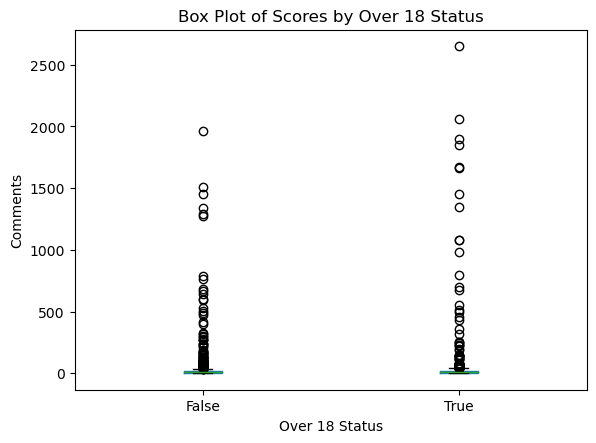

In [34]:

# simple plot for checking the data
plt.figure(figsize=(10, 6))
ax = pandas_df.boxplot(by='over_18', column=['num_comments'], grid=False)

# format
ax.set_title('Box Plot of Scores by Over 18 Status')
ax.set_xlabel('Over 18 Status')
ax.set_ylabel('Comments')
plt.suptitle('') 

# show
plt.show()


<Figure size 1000x600 with 0 Axes>

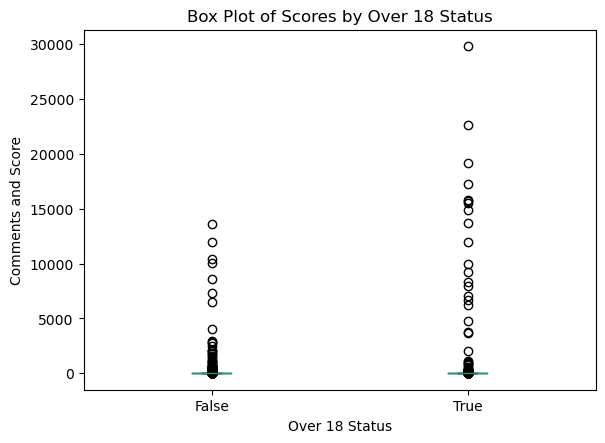

In [35]:
# simple plot for checking the data
plt.figure(figsize=(10, 6))
ax = pandas_df.boxplot(by='over_18', column=['interaction_score'], grid=False)

# format
ax.set_title('Box Plot of Scores by Over 18 Status')
ax.set_xlabel('Over 18 Status')
ax.set_ylabel('Comments and Score')
plt.suptitle('') 

# show
plt.show()

In [36]:
# check
counts = pandas_df['over_18'].value_counts()
print("Counts for 'over_18' in the DataFrame:")
print(counts)


Counts for 'over_18' in the DataFrame:
True     1181
False    1181
Name: over_18, dtype: int64


Topic 2

In [37]:

# group by 'subreddit' and calculate the mean of 'num_comments' and 'score'
subreddit_means = submissions_active.groupBy('subreddit') \
                                    .agg(F.mean('num_comments').alias('mean_num_comments'), 
                                         F.mean('score').alias('mean_score'))

# convert to pandas
pandas_df_means = subreddit_means.toPandas()

# ensure the 'subreddit' is treated as a category
pandas_df_means['subreddit'] = pandas_df_means['subreddit'].astype('category')

# save data
pandas_df_means.to_csv('../../data/eda-plots/mean-comments-vs-mean-score-data.csv', index=False)




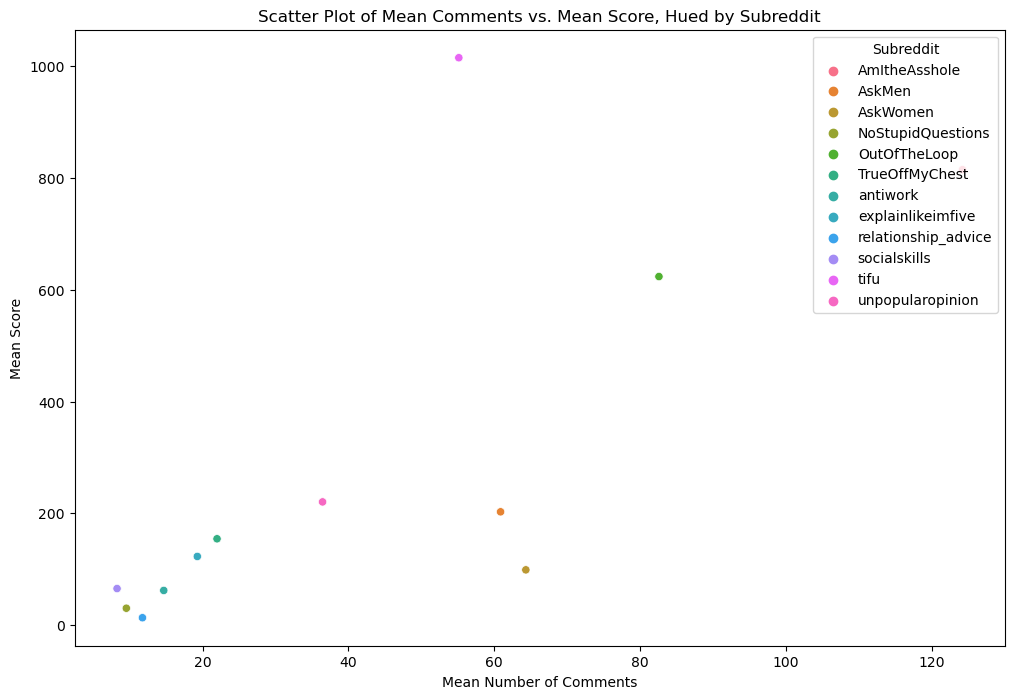

In [38]:

# basic plot for checking data
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(data=pandas_df_means, 
                               x='mean_num_comments', 
                               y='mean_score', 
                               hue='subreddit')

# format
scatter_plot.set_title('Scatter Plot of Mean Comments vs. Mean Score, Hued by Subreddit')
scatter_plot.set_xlabel('Mean Number of Comments')
scatter_plot.set_ylabel('Mean Score')
plt.legend(title='Subreddit', loc='upper right')


# show
plt.show()



Topic 3

In [39]:

# filter out before Jan 3rd, 2021 and it will be considered week 53 of 2020
comments_active = comments_active.filter(to_date(col('created_utc')) > lit('2021-01-03'))


# group and pivot
comments_grouped = comments_active.groupBy('week_of_year', 'hour_of_day').count()
comments_pivot = comments_grouped.groupBy('week_of_year').pivot('hour_of_day').avg('count').orderBy('week_of_year')

# convert to pandas
comments_pivot_df = comments_pivot.toPandas().set_index('week_of_year')


# save
comments_pivot_df.to_csv('../../data/eda-plots/average-comments-hour-and-week-data.csv', index=True)



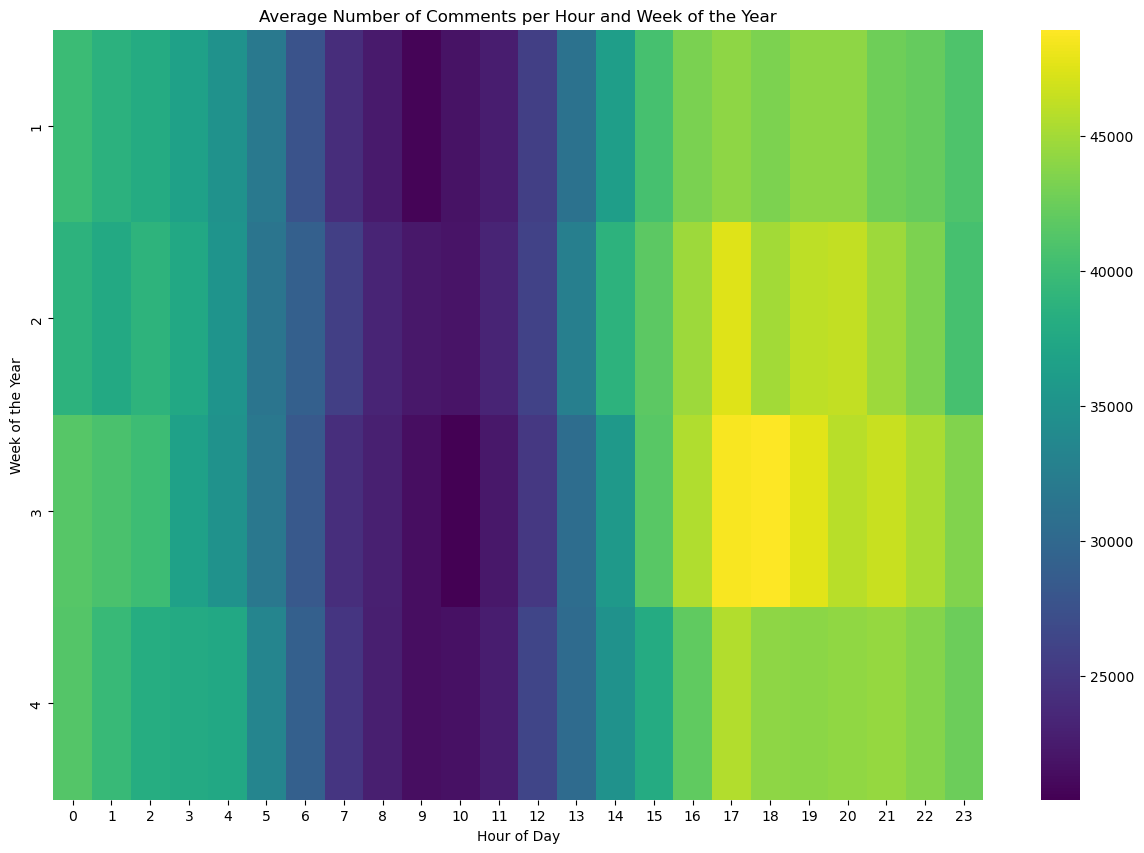

In [40]:
# basic plot for checking data
plt.figure(figsize=(15, 10))
sns.heatmap(comments_pivot_df, cmap='viridis')
plt.title('Average Number of Comments per Hour and Week of the Year')
plt.xlabel('Hour of Day')
plt.ylabel('Week of the Year')
plt.show()



### 2.4 Produce at least 3 interesting summary tables about your dataset. You can decide how to split up your data into categories, time slices, etc. There are infinite ways you can make summary statistics. Be unique, creative, and interesting!



In [41]:
# calculate correlations
correlation_by_subreddit = submissions_active.groupBy('subreddit') \
                                             .agg(corr(col('num_comments'), col('score')).alias('correlation_coefficient'))
correlation_by_subreddit.show()


# pd and save
pandas_df_correlation_table = correlation_by_subreddit.toPandas()
pandas_df_correlation_table.to_csv('../../data/eda-plots/correlation_by_subreddit.csv', index=False)


+-------------------+-----------------------+
|          subreddit|correlation_coefficient|
+-------------------+-----------------------+
|     TrueOffMyChest|     0.8545432276488629|
|   unpopularopinion|      0.843296536142201|
|           antiwork|     0.8068856199690001|
|       socialskills|      0.834382506259139|
|             AskMen|     0.8468371697875884|
|      AmItheAsshole|     0.8104258004972631|
|relationship_advice|     0.7381668983737222|
|  explainlikeimfive|     0.8527938151180964|
|       OutOfTheLoop|     0.9203358971690881|
|               tifu|      0.931179178568243|
|  NoStupidQuestions|     0.7273653903052063|
|           AskWomen|     0.8411305643519686|
+-------------------+-----------------------+



### 2.6 Implement regex searches for specific keywords of interest to produce dummy variables and then make statistics that are related to your business questions. Note, that you DO NOT have to do textual cleaning of the data at this point. The next assignment on NLP will focus on the textual cleaning and analysis aspect.



In [43]:

keywords = ['fascinating', 'entertaining', 'boring']
combined_counts = {}

# init dataframe not work on original
comments_active_dummies = comments_active


# create dummies
for keyword in keywords:
    comments_active_dummies = comments_active_dummies.withColumn(
        keyword, 
        (regexp_extract(col('body'), f'\\b{keyword}\\b', 0) != '').cast('integer')
    )



# loop through keyworkds, get count and collect
for keyword in keywords:
    count_df = comments_active_dummies.groupBy(keyword).count().toPandas()
    count_df.set_index(keyword, inplace=True)  # Set the keyword column as the index
    combined_counts[keyword] = count_df

    
# concat
combined_df = pd.concat(combined_counts.values(), axis=1, keys=combined_counts.keys())

# check
print(combined_df)


# save data

combined_df.to_csv('../../data/eda-plots/dummies_keywords_count.csv')



  fascinating entertaining   boring
        count        count    count
1        2180         1877     6473
0     3417116      3417419  3412823


### 2.7 Find some type of external data to join onto your Reddit data. Don’t know what to pick? Consider a time-related dataset. Stock prices, game details over time, active users on a platform, sports scores, covid cases, etc., etc. While you may not need to join this external data with your entire dataset, you must have at least one analysis that connects to external data. You do not have to join the external data and analyze it yet, just find it.



### If you are planning to make any custom datasets that are derived from your Reddit data, make them now. These datasets might be graph-focused, or maybe they are time series focused, it is completely up to you!